In [42]:
from hcipy import *
import numpy as np
from matplotlib import pyplot as plt

N = 64
D = 9.96
aperture = circular_aperture(D)
pupil_grid = make_pupil_grid(N, D)
sps = 40 * N // 128
pupsep = 1
outgrid_size = int(np.ceil(sps * (pupsep + 1)))
D_grid = 3.6e-3
pyramid_grid = make_pupil_grid(N, D_grid)
outgrid = np.zeros((N, N)).tolist()
buffer = (N - 2 * outgrid_size)//2

def aberration_basis(N):
    wfref = Wavefront(aperture(pupil_grid))
    wfref.electric_field.shape = (N, N)
    wfrefl = wfref.electric_field.tolist()
    aberration_mode_basis = []
    for i in range(N):
        for j in range(N):
            l = np.zeros((N, N), dtype=complex)
            if np.complex(wfrefl[i][j]) != 0:
                l[i][j] = 1j
                aberration_mode_basis.append(Wavefront(Field(np.round(np.asarray(l).ravel(), 3) * aperture(pupil_grid), wfref.grid)))
    return aberration_mode_basis

basis = aberration_basis(N)

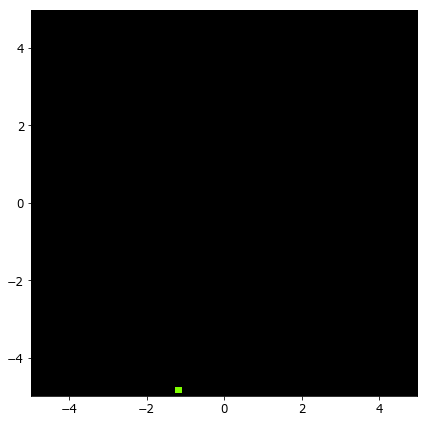

In [43]:
imshow_field(basis[0].electric_field)
plt.show()

#okay so the basis is getting created correctly that's not the problem. Let's propagate each of these.

In [13]:
def get_sub_images(electric_field):
    pyramid_grid = make_pupil_grid(N, D_grid)
    images = Field(np.asarray(electric_field).ravel(), pyramid_grid)
    pysize = int(np.sqrt(images.size))
    images.shape = (pysize, pysize)
    sub_images = [images[pysize-sps-1:pysize-1, 0:sps], images[pysize-sps-1:pysize-1, pysize-sps-1:pysize-1],
                  images[0:sps, 0:sps], images[0:sps, pysize-sps-1:pysize-1]]
    subimage_grid = make_pupil_grid(sps, D_grid * sps / N)
    for count, img in enumerate(sub_images):
        img = img.ravel()
        img.grid = subimage_grid
        sub_images[count] = img
    return sub_images

def pyramid_prop(wf):
    # Given a wavefront, returns the result of a pyramid propagation and splitting into sub-images, 
    # as a list of hcipy Field objects.
    keck_pyramid = PyramidWavefrontSensorOptics(pupil_grid, pupil_separation=pupsep, num_pupil_pixels=sps)
    return get_sub_images(keck_pyramid.forward(wf).electric_field)

def estimate(images_list):
    EstimatorObject = PyramidWavefrontSensorEstimator(aperture, make_pupil_grid(sps*2, D_grid*sps*2/N))
    I_b = images_list[0]
    I_a = images_list[1]
    I_c = images_list[2]
    I_d = images_list[3]
    norm = I_a + I_b + I_c + I_d
    I_x = (I_a + I_b - I_c - I_d) / norm
    I_y = (I_a - I_b - I_c + I_d) / norm
    pygrid = make_pupil_grid(sps)
    return Field(I_x.ravel(), pygrid), Field(I_y.ravel(), pygrid)

def make_slopes(wf):
    x, y = estimate(pyramid_prop(wf))
    return np.concatenate((x, y))

In [44]:
slopes_basis = [make_slopes(basis_element) for basis_element in basis]

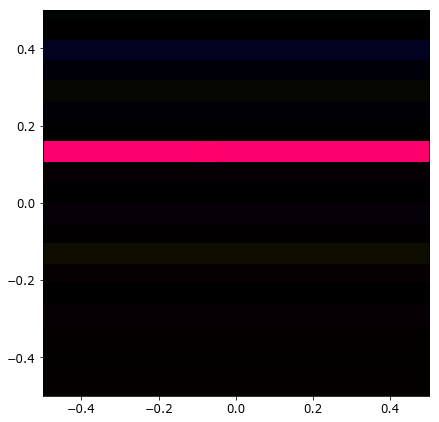

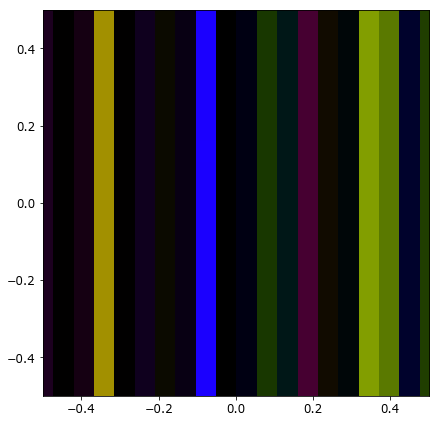

In [47]:
imshow_field(slopes_basis[0][0:sps*sps], make_pupil_grid(sps))
plt.show()
imshow_field(slopes_basis[0][sps*sps:2*sps*sps], make_pupil_grid(sps))
plt.show()

In [17]:
len(basis)

172

In [48]:
flat_slopes = make_slopes(Wavefront(aperture(pupil_grid)))

In [49]:
spsg = make_pupil_grid(sps)

In [51]:
flat_x = Field(flat_slopes[0:sps*sps], spsg)
flat_y = Field(flat_slopes[sps*sps:2*sps*sps], spsg)

In [25]:
def least_inv(A):
    # given a matrix A such that Ax = b, makes a least-squares matrix Y such that
    # x^ = Yb.
    return np.linalg.inv(A.T.dot(A)).dot(A.T)

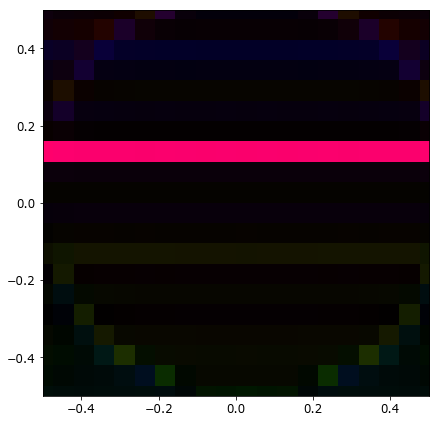

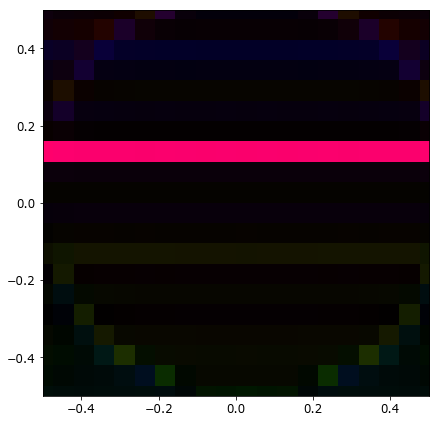

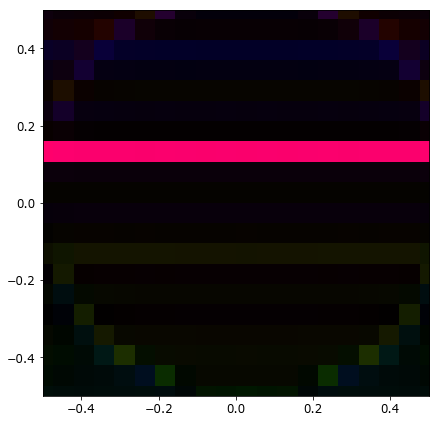

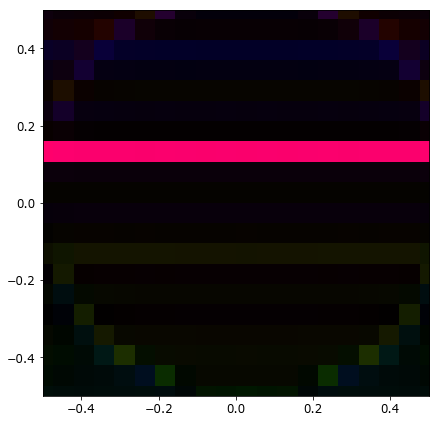

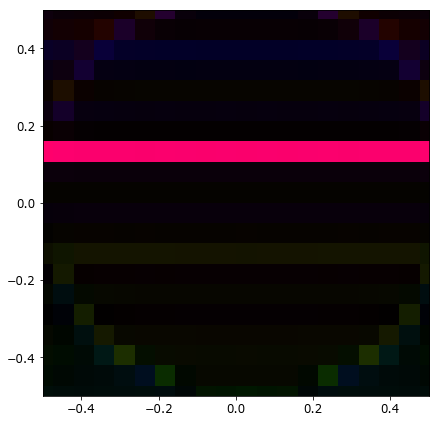

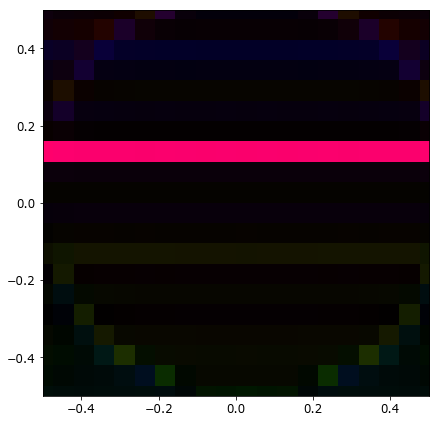

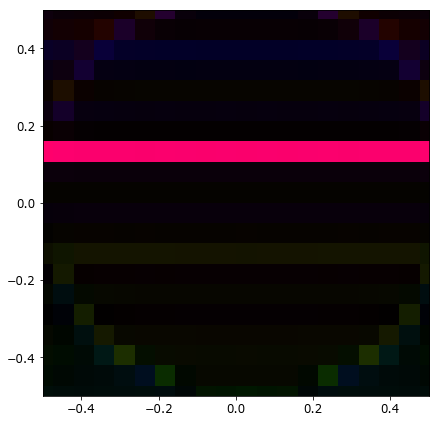

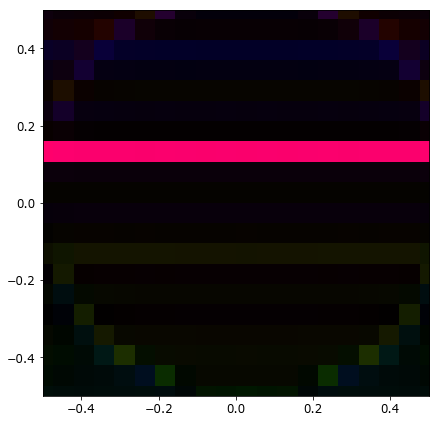

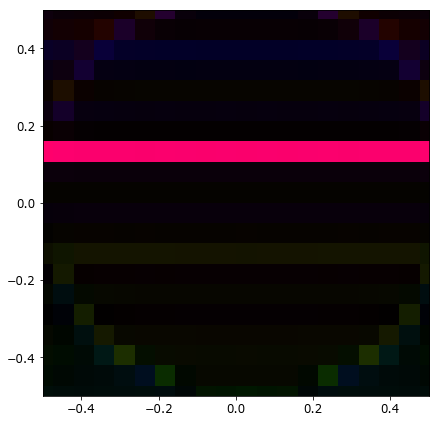

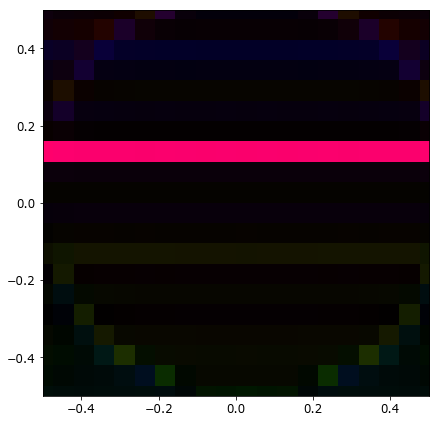

In [52]:
for i in range(10):
    imshow_field(slopes_basis[i][0:sps*sps] - flat_x)
    plt.show()

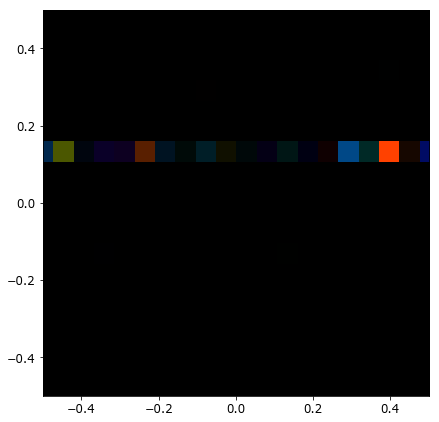

In [63]:
imshow_field(slopes_basis[sps-5][0:sps*sps] - slopes_basis[0][0:sps*sps], spsg)
plt.show()


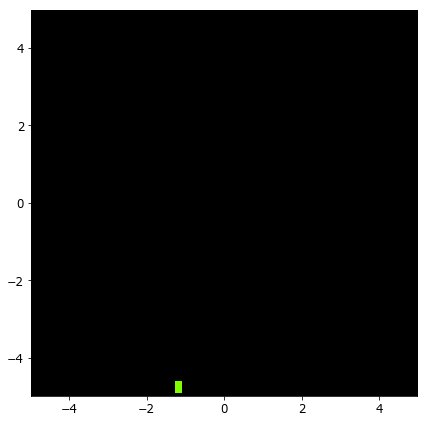

In [65]:
# let's do a simple test. Adding together the first two basis elements:

test = Wavefront(basis[0].electric_field + basis[sps-1].electric_field)
imshow_field(test.electric_field)
plt.show()

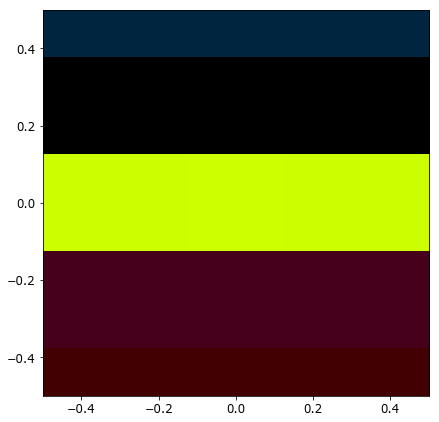

In [35]:
# Cool. Now let's propagate this through the pyramid

test_slopes = make_slopes(test)
imshow_field(test_slopes[0:25], make_pupil_grid(5))
plt.show()
test_x = Field(test_slopes[0:25], make_pupil_grid(5))
test_y = Field(test_slopes[25:50], make_pupil_grid(5))

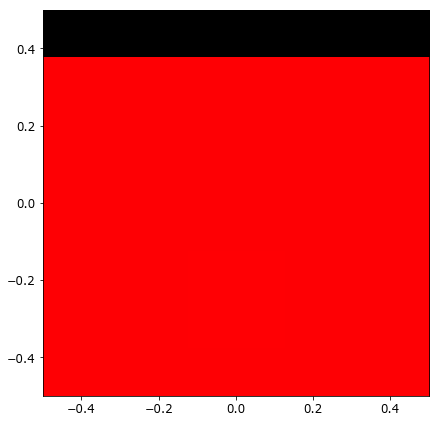

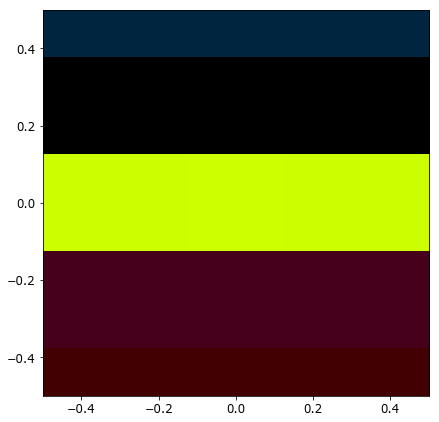

In [66]:
# Now for some comparisons. First the x:

imshow_field(slopes_basis[0][0:25] + slopes_basis[sps-1][0:25], make_pupil_grid(5))
plt.show()
imshow_field(test_x)
plt.show()

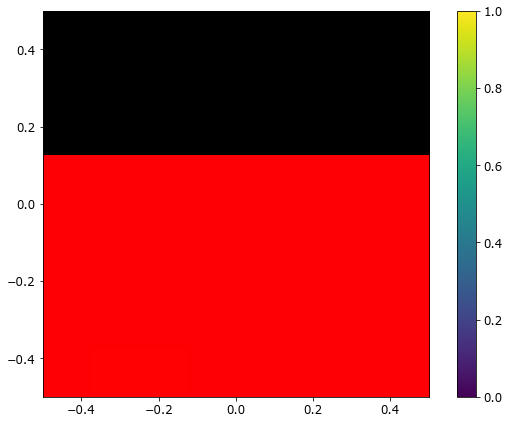

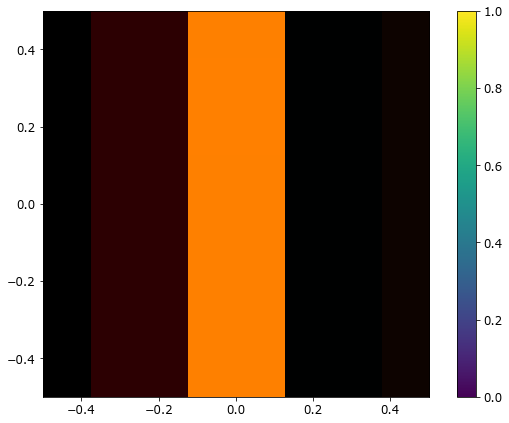

In [67]:
# Now the y:

imshow_field(slopes_basis[0][25:50] + slopes_basis[sps-1][25:50], make_pupil_grid(5))
plt.colorbar()
plt.show()
imshow_field(test_y)
plt.colorbar()
plt.show()

In [ ]:
# Weird. Linearity in x is fine, in y is not. Let's up the N. 